### This document is for linking REDCap, ACCESS, and TSQIC datasets, where each row represents an id+surgery.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import ast

# TSQIC tabs merging

In [295]:
# Load the Excel file
file_path = "Complications_TSQIC_TC_13_02_2025.xlsx" 
df_tsqic = pd.read_excel(file_path, sheet_name=None)

# Display sheet names
print(df_tsqic.keys())

# Access specific sheets/tabs
df_tsqic_1 = df_tsqic["TSQIC-Complications"]  
df_tsqic_2 = df_tsqic["TSQIC-admission-discharge dates"] 
print(df_tsqic_1)
print(df_tsqic_2)

dict_keys(['TSQIC-Complications', 'TSQIC-admission-discharge dates'])
        id date (operation) ComplicationDate     System       Complication  \
0      817       2016-09-07       2016-09-08    Cardiac       Hypotension    
1      190       2016-09-07       2016-09-08    Cardiac  Atrial Arrhythmia   
2      817       2016-09-07       2016-09-09    Cardiac  Atrial Arrhythmia   
3      190       2016-09-07       2016-09-10  Pulmonary         Hemoptysis   
4      817       2016-09-07       2016-09-11    Cardiac       Hypertension   
...    ...              ...              ...        ...                ...   
1557  1705       2024-09-04       2024-09-10  Pulmonary        Atelactasis   
1558  1705       2024-09-04       2024-09-10    Pleural           Effusion   
1559  1705       2024-09-04       2024-09-11      Anast   Mucosal necrosis   
1560  1687       2024-09-08       2024-09-16    Pleural           Effusion   
1561  1687       2024-09-08       2024-09-16    Pleural  Hydropneumothor

In [296]:
# Standardize column names for merging
df_tsqic_1 = df_tsqic_1.rename(columns={"date (operation)": "operation_date", "Readmission":"readmission_30d"})
df_tsqic_2 = df_tsqic_2.rename(columns={"Date (operation)": "operation_date"})


# Convert operation_date to datetime for proper matching
df_tsqic_1["operation_date"] = pd.to_datetime(df_tsqic_1["operation_date"])
df_tsqic_2["operation_date"] = pd.to_datetime(df_tsqic_2["operation_date"])

In [297]:
# Remove unusable columns
df_tsqic_1 = df_tsqic_1.drop(columns=['System', 'Complication', "Grade", "GradeLetter", "Prolonged", "Comments"])
df_tsqic_1

,id,operation_date,ComplicationDate,readmission_30d
0,817,2016-09-07,2016-09-08,0
1,190,2016-09-07,2016-09-08,0
2,817,2016-09-07,2016-09-09,0
3,190,2016-09-07,2016-09-10,0
4,817,2016-09-07,2016-09-11,0
...,...,...,...,...
1557,1705,2024-09-04,2024-09-10,0
1558,1705,2024-09-04,2024-09-10,0
1559,1705,2024-09-04,2024-09-11,0
1560,1687,2024-09-08,2024-09-16,0


In [298]:
def merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2):
    """
    Merge two dataframes in a longitudinal format while keeping original column structure
    and preserving original data types.
    """
    # Function to add sequence numbers
    def add_sequence(df):
        df = df.copy()
        df['seq'] = df.groupby(['id', 'operation_date']).cumcount() + 1
        return df

    # Add sequence numbers
    df1_seq = add_sequence(df_tsqic_1)
    df2_seq = add_sequence(df_tsqic_2)

    # Merge both datasets on (id, operation_date, seq)
    merged_df = df1_seq.merge(df2_seq, on=['id', 'operation_date', 'seq'], how='outer')

    # Drop 'seq' column after merging
    merged_df = merged_df.drop(columns=['seq'])

    # Rename columns to remove 'df1_' and 'df2_' prefixes
    new_columns = {col: col.replace('df1_', '').replace('df2_', '') for col in merged_df.columns}
    merged_df = merged_df.rename(columns=new_columns)

    # Identify numeric and datetime columns
    numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
    datetime_cols = merged_df.select_dtypes(include=[np.datetime64]).columns

    # Group by id, operation_date
    def custom_agg(series):
        unique_values = series.dropna().unique()
        
        if series.name in numeric_cols:
            return list(map(float, unique_values))  # Keep numbers as list of floats/ints
        
        elif series.name in datetime_cols:
            return list(pd.to_datetime(unique_values))  # Keep dates as list of datetime objects
        
        return ', '.join(map(str, unique_values))  # Join text/categorical values

    merged_df = merged_df.groupby(['id', 'operation_date']).agg(custom_agg).reset_index()

    return merged_df

# Run function
merged_matched = merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2)
print(merged_matched)










'''
def merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2):
    """
    Merge two dataframes in a longitudinal format while keeping original column structure
    and aggregating duplicate values into comma-separated lists.
    """
    # Add a sequence number for duplicates within each group
    def add_sequence(df, prefix):
        df = df.copy()
        df['seq'] = df.groupby(['id', 'operation_date']).cumcount() + 1
        df.columns = [f"{prefix}_{col}" if col not in ['id', 'operation_date', 'seq'] else col 
                    for col in df.columns]
        return df

    # Process each dataframe
    df1_seq = add_sequence(df_tsqic_1, 'df1')
    df2_seq = add_sequence(df_tsqic_2, 'df2')

    # Merge on (id, operation_date)
    merged_df = df1_seq.merge(df2_seq, on=['id', 'operation_date', 'seq'], how='outer')

    # Remove the 'seq' column since we will aggregate duplicates
    merged_df = merged_df.drop(columns=['seq'])

    # Group by id, operation_date, and aggregate duplicate column values
    merged_df = merged_df.groupby(['id', 'operation_date']).agg(lambda x: ', '.join(x.dropna().astype(str))).reset_index()

    return merged_df


merged_matched = merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2)
print(merged_matched)
'''










'''
# using pivot and reshape
def merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2):
    """
    pivot_table to create longitudinal format
    """
    # Add a sequence number for duplicates within each group
    def add_sequence(df, prefix):
        # Make a copy to avoid modifying the original
        df = df.copy()
        
        # Add a sequence number within each id/operation_date group
        df['seq'] = df.groupby(['id', 'operation_date']).cumcount() + 1
        
        # Add source prefix to columns except id and operation_date
        df.columns = [f"{prefix}_{col}" if col not in ['id', 'operation_date', 'seq'] else col 
                    for col in df.columns]
        
        return df
    
    # Process each dataframe
    df1_seq = add_sequence(df_tsqic_1, 'df1')
    df2_seq = add_sequence(df_tsqic_2, 'df2')
    
    
    
    # Melt each dataframe to long format
    def melt_to_long(df, id_vars=['id', 'operation_date', 'seq'], prefix=''):
        melted = pd.melt(
            df, 
            id_vars=id_vars,
            var_name='variable',
            value_name='value'
        )
        # Combine variable and sequence for unique column names
        melted['variable_seq'] = melted['variable'] + '_' + melted['seq'].astype(str)
        return melted[['id', 'operation_date', 'variable_seq', 'value']]
    
    df1_long = melt_to_long(df1_seq, prefix='df1')
    df2_long = melt_to_long(df2_seq, prefix='df2')
    
    # Get all unique (id, operation_date) pairs
    all_unique_pairs = pd.concat([
        df_tsqic_1[['id', 'operation_date']],
        df_tsqic_2[['id', 'operation_date']]
    ]).drop_duplicates()
    
    # Merge melted data with full set of unique pairs
    df1_long = all_unique_pairs.merge(df1_long, on=['id', 'operation_date'], how='left')
    df2_long = all_unique_pairs.merge(df2_long, on=['id', 'operation_date'], how='left')

    
    # Combine melted data
    combined_long = pd.concat([df1_long, df2_long], ignore_index=True)

    
    # Pivot back to wide format into separate columns
    # merged_df = combined_long.pivot(
    #     index=['id', 'operation_date'],
    #     columns='variable_seq',
    #     values='value'
    # ).reset_index()
    
    # Group by (id, operation_date) and aggregate values into a comma-separated string
    merged_df = combined_long.groupby(['id', 'operation_date']).agg(lambda x: ', '.join(x.dropna().astype(str))).reset_index()

    # Flatten the column names
    merged_df.columns.name = None
    
    return merged_df



merged_matched = merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2)
print(merged_matched)
'''

        id operation_date                                   ComplicationDate  \
0       37     2023-05-03                                                 []   
1       44     2019-05-21                                                 []   
2       55     2019-10-22                                                 []   
3       76     2021-05-18                              [2021-05-21 00:00:00]   
4       78     2019-09-03                                                 []   
...    ...            ...                                                ...   
1221  1722     2024-08-27  [2024-08-27 00:00:00, 2024-08-28 00:00:00, 202...   
1222  1748     2024-07-23         [2024-08-12 00:00:00, 2024-08-13 00:00:00]   
1223  1748     2024-08-13                              [2024-08-16 00:00:00]   
1224  1748     2024-08-19                              [2024-08-21 00:00:00]   
1225  1748     2024-08-26                                                 []   

     readmission_30d          Discharge

'\n# using pivot and reshape\ndef merge_to_longitudinal_pivot(df_tsqic_1, df_tsqic_2):\n    """\n    pivot_table to create longitudinal format\n    """\n    # Add a sequence number for duplicates within each group\n    def add_sequence(df, prefix):\n        # Make a copy to avoid modifying the original\n        df = df.copy()\n        \n        # Add a sequence number within each id/operation_date group\n        df[\'seq\'] = df.groupby([\'id\', \'operation_date\']).cumcount() + 1\n        \n        # Add source prefix to columns except id and operation_date\n        df.columns = [f"{prefix}_{col}" if col not in [\'id\', \'operation_date\', \'seq\'] else col \n                    for col in df.columns]\n        \n        return df\n    \n    # Process each dataframe\n    df1_seq = add_sequence(df_tsqic_1, \'df1\')\n    df2_seq = add_sequence(df_tsqic_2, \'df2\')\n    \n    \n    \n    # Melt each dataframe to long format\n    def melt_to_long(df, id_vars=[\'id\', \'operation_date\', \'

In [299]:
# Assuming you have two dataframes: df1 and df2
# Each with columns 'id' and 'operation_date'
df1= df_tsqic_1.copy()
df2= df_tsqic_2.copy()

# Count total rows in each original dataset
total_rows_df1 = df1.shape[0]
total_rows_df2 = df2.shape[0]

print(f"total_rows_df1: {total_rows_df1}")
print(f"total_rows_df2: {total_rows_df2}")
    
# Method 1: Count unique combinations in each dataframe separately
unique_pairs_df1 = df1.drop_duplicates(subset=['id', 'operation_date']).shape[0]
unique_pairs_df2 = df2.drop_duplicates(subset=['id', 'operation_date']).shape[0]
unique_pairs_merged = merged_matched[['id', 'operation_date']].drop_duplicates().shape[0]

print(f"Unique pairs in first dataset: {unique_pairs_df1}")
print(f"Unique pairs in second dataset: {unique_pairs_df2}")
print(f"Unique pairs merged: {unique_pairs_merged}")


# Method 2: Find unique pairs across both dataframes combined
# Concatenate both dataframes
combined_df = pd.concat([df1, df2])
unique_pairs_combined = combined_df.drop_duplicates(subset=['id', 'operation_date']).shape[0]

print(f"Unique pairs across both datasets: {unique_pairs_combined}")

# Method 3: Find pairs that are in both datasets (intersection)
pairs_df1 = set(zip(df1['id'], df1['operation_date']))
pairs_df2 = set(zip(df2['id'], df2['operation_date']))
common_pairs = pairs_df1.intersection(pairs_df2)

print(f"Pairs that appear in both datasets: {len(common_pairs)}")

# Method 4: Find pairs that are only in dataset 1
only_in_df1 = pairs_df1 - pairs_df2
print(f"Pairs only in first dataset: {len(only_in_df1)}")

# Method 5: Find pairs that are only in dataset 2
only_in_df2 = pairs_df2 - pairs_df1
print(f"Pairs only in second dataset: {len(only_in_df2)}")

# Debug: Check for any rows that might be getting lost
combined_unique_df = pd.concat([
    df_tsqic_1[['id', 'operation_date']].drop_duplicates(),
    df_tsqic_2[['id', 'operation_date']].drop_duplicates()
]).drop_duplicates()

# Find the missing pairs
missing_pairs = set(map(tuple, combined_unique_df.values)) - set(map(tuple, merged_matched[['id', 'operation_date']].values))
print(f"Number of missing pairs: {len(missing_pairs)}")
if missing_pairs:
    print("Sample of missing pairs:", list(missing_pairs))

total_rows_df1: 1562
total_rows_df2: 1260
Unique pairs in first dataset: 562
Unique pairs in second dataset: 1226
Unique pairs merged: 1226
Unique pairs across both datasets: 1226
Pairs that appear in both datasets: 562
Pairs only in first dataset: 0
Pairs only in second dataset: 664
Number of missing pairs: 0


In [300]:
#create a new binary column postop_comp
merged_matched['postop_comp'] = merged_matched['ComplicationDate'].apply(lambda x: 1 if x else 0)
merged_matched

,id,operation_date,ComplicationDate,readmission_30d,DischargeDate,postop_comp
0,37,2023-05-03,[],[],[2023-05-06 00:00:00],0
1,44,2019-05-21,[],[],[2019-05-23 00:00:00],0
2,55,2019-10-22,[],[],[2019-10-28 00:00:00],0
3,76,2021-05-18,[2021-05-21 00:00:00],[0.0],[2021-05-25 00:00:00],1
4,78,2019-09-03,[],[],[2020-09-10 00:00:00],0
...,...,...,...,...,...,...
1221,1722,2024-08-27,"[2024-08-27 00:00:00, 2024-08-28 00:00:00, 202...",[0.0],[2024-09-03 00:00:00],1
1222,1748,2024-07-23,"[2024-08-12 00:00:00, 2024-08-13 00:00:00]","[1.0, 0.0]",[2024-07-30 00:00:00],1
1223,1748,2024-08-13,[2024-08-16 00:00:00],[0.0],[2024-08-30 00:00:00],1
1224,1748,2024-08-19,[2024-08-21 00:00:00],[0.0],[2024-08-30 00:00:00],1


In [301]:
# Filter rows where at least one ComplicationDate is within 90 days of operation_date
# Only exclude missing values, keep empty lists
df_filtered = merged_matched[
    (merged_matched["ComplicationDate"].notna()) & # Exclude missing values
    (merged_matched.apply(
        lambda row: len(row["ComplicationDate"]) == 0 or # Keep empty lists
        any(
            (pd.to_datetime(d) - pd.to_datetime(row["operation_date"])).days <= 90 
            for d in row["ComplicationDate"]
        ), axis=1
    ))
]

# Print info about filtered rows
print("Original rows:", len(merged_matched))
print("Filtered rows:", len(df_filtered))
print("Number of rows filtered out:", len(merged_matched) - len(df_filtered))

# Show the rows that were filtered out
filtered_out = merged_matched[~merged_matched.index.isin(df_filtered.index)]
print("\nRows that were filtered out:")
print(filtered_out[['id', 'operation_date', 'ComplicationDate']])

merged_matched = df_filtered.copy()
merged_matched

Original rows: 1226
Filtered rows: 1223
Number of rows filtered out: 3

Rows that were filtered out:
       id operation_date       ComplicationDate
88    497     2017-12-24  [2018-04-05 00:00:00]
166   658     2017-01-17  [2017-05-02 00:00:00]
877  1277     2021-09-01  [2021-12-11 00:00:00]


,id,operation_date,ComplicationDate,readmission_30d,DischargeDate,postop_comp
0,37,2023-05-03,[],[],[2023-05-06 00:00:00],0
1,44,2019-05-21,[],[],[2019-05-23 00:00:00],0
2,55,2019-10-22,[],[],[2019-10-28 00:00:00],0
3,76,2021-05-18,[2021-05-21 00:00:00],[0.0],[2021-05-25 00:00:00],1
4,78,2019-09-03,[],[],[2020-09-10 00:00:00],0
...,...,...,...,...,...,...
1221,1722,2024-08-27,"[2024-08-27 00:00:00, 2024-08-28 00:00:00, 202...",[0.0],[2024-09-03 00:00:00],1
1222,1748,2024-07-23,"[2024-08-12 00:00:00, 2024-08-13 00:00:00]","[1.0, 0.0]",[2024-07-30 00:00:00],1
1223,1748,2024-08-13,[2024-08-16 00:00:00],[0.0],[2024-08-30 00:00:00],1
1224,1748,2024-08-19,[2024-08-21 00:00:00],[0.0],[2024-08-30 00:00:00],1


In [302]:
# Remove unusable columns
merged_matched = merged_matched.drop(columns=["ComplicationDate"])
merged_matched

,id,operation_date,readmission_30d,DischargeDate,postop_comp
0,37,2023-05-03,[],[2023-05-06 00:00:00],0
1,44,2019-05-21,[],[2019-05-23 00:00:00],0
2,55,2019-10-22,[],[2019-10-28 00:00:00],0
3,76,2021-05-18,[0.0],[2021-05-25 00:00:00],1
4,78,2019-09-03,[],[2020-09-10 00:00:00],0
...,...,...,...,...,...
1221,1722,2024-08-27,[0.0],[2024-09-03 00:00:00],1
1222,1748,2024-07-23,"[1.0, 0.0]",[2024-07-30 00:00:00],1
1223,1748,2024-08-13,[0.0],[2024-08-30 00:00:00],1
1224,1748,2024-08-19,[0.0],[2024-08-30 00:00:00],1


In [303]:
# Function to calculate estimated_los
def calculate_los(row):
    operation_date = row['operation_date']
    discharge_dates = row['DischargeDate']
    
    # If operation_date is missing, return NaN
    if pd.isna(operation_date):
        return np.nan
    
    # Handle different types of DischargeDate
    if isinstance(discharge_dates, list):
        # If empty list, return NaN
        if len(discharge_dates) == 0:
            return np.nan
        # Calculate LOS for each discharge date in list
        los_values = [(date - operation_date).days for date in discharge_dates]
        return los_values
    
    # Check if DischargeDate is missing (direct comparison)
    elif pd.isna(discharge_dates):
        return np.nan
    
    # If single discharge date
    elif isinstance(discharge_dates, pd.Timestamp):
        return (discharge_dates - operation_date).days
    
    # Catch-all for unexpected data
    else:
        return np.nan

# Apply the function to each row
merged_matched['estimated_los'] = merged_matched.apply(calculate_los, axis=1)
merged_matched

,id,operation_date,readmission_30d,DischargeDate,postop_comp,estimated_los
0,37,2023-05-03,[],[2023-05-06 00:00:00],0,[3]
1,44,2019-05-21,[],[2019-05-23 00:00:00],0,[2]
2,55,2019-10-22,[],[2019-10-28 00:00:00],0,[6]
3,76,2021-05-18,[0.0],[2021-05-25 00:00:00],1,[7]
4,78,2019-09-03,[],[2020-09-10 00:00:00],0,[373]
...,...,...,...,...,...,...
1221,1722,2024-08-27,[0.0],[2024-09-03 00:00:00],1,[7]
1222,1748,2024-07-23,"[1.0, 0.0]",[2024-07-30 00:00:00],1,[7]
1223,1748,2024-08-13,[0.0],[2024-08-30 00:00:00],1,[17]
1224,1748,2024-08-19,[0.0],[2024-08-30 00:00:00],1,[11]


In [304]:
# For summary statistics of los, we need to flatten the lists
# First, let's create a flattened series of all LOS values
all_los_values = []
for los in merged_matched["estimated_los"]:
    if isinstance(los, list):
        all_los_values.extend(los)
    elif not pd.isna(los):
        all_los_values.append(los)

# Now we can get summary statistics on the flattened values
flattened_los = pd.Series(all_los_values)
print(flattened_los.describe())  # Summary statistics
print("\n\n")

# For negative values, we need to check each value in lists
neg_los_rows = []
for idx, row in merged_matched.iterrows():
    los = row["estimated_los"]
    if isinstance(los, list) and any(val < 0 for val in los):
        neg_los_rows.append(idx)
    elif not isinstance(los, list) and not pd.isna(los) and los < 0:
        neg_los_rows.append(idx)

print(merged_matched.loc[neg_los_rows])  # Check for negative LOS values
print("\n\n")

# For NA values, we can use pandas isna directly
print(merged_matched[merged_matched["estimated_los"].isna()])  # Check for missing values
print("\n\n")

count    1192.000000
mean       18.586409
std        34.362799
min      -358.000000
25%         6.000000
50%         8.000000
75%        22.000000
max       422.000000
dtype: float64



        id operation_date readmission_30d  \
928   1318     2021-12-03              []   
1070  1549     2023-03-01           [0.0]   

                                   DischargeDate  postop_comp estimated_los  
928                        [2021-01-07 00:00:00]            0        [-330]  
1070  [2022-03-08 00:00:00, 2023-03-08 00:00:00]            1     [-358, 7]  



        id operation_date readmission_30d DischargeDate  postop_comp  \
45     230     2019-07-30              []            []            0   
78     424     2016-12-28           [0.0]            []            1   
79     424     2017-01-10              []            []            0   
99     533     2017-09-26              []            []            0   
165    653     2017-01-17           [0.0]            []            1   
183    66

In [305]:
merged_matched

,id,operation_date,readmission_30d,DischargeDate,postop_comp,estimated_los
0,37,2023-05-03,[],[2023-05-06 00:00:00],0,[3]
1,44,2019-05-21,[],[2019-05-23 00:00:00],0,[2]
2,55,2019-10-22,[],[2019-10-28 00:00:00],0,[6]
3,76,2021-05-18,[0.0],[2021-05-25 00:00:00],1,[7]
4,78,2019-09-03,[],[2020-09-10 00:00:00],0,[373]
...,...,...,...,...,...,...
1221,1722,2024-08-27,[0.0],[2024-09-03 00:00:00],1,[7]
1222,1748,2024-07-23,"[1.0, 0.0]",[2024-07-30 00:00:00],1,[7]
1223,1748,2024-08-13,[0.0],[2024-08-30 00:00:00],1,[17]
1224,1748,2024-08-19,[0.0],[2024-08-30 00:00:00],1,[11]


In [306]:
# #Simpler alternative way
# merged_matchedxx = df_tsqic_1.merge(df_tsqic_2, on=["id", "operation_date"], how="outer", indicator=False)
# merged_matchedxx

# merged_matchedxx["estimated_los"] = (merged_matchedxx["DischargeDate"] - merged_matchedxx["operation_date"]).dt.days

# merged_matchedxx['postop_comp'] = merged_matchedxx['ComplicationDate'].notna().astype(int)
# merged_matchedxx

# merged_matchedxx = merged_matchedxx.drop(columns=["ComplicationDate"])
# merged_matchedxx


# def safe_unique(series):
#     """ Ensure values are flattened before applying .unique() """
#     flattened = series.explode()  # Unpack lists if they exist
#     unique_values = flattened.dropna().unique()  # Get unique non-null values
#     return list(unique_values) if len(unique_values) > 1 else (unique_values[0] if len(unique_values) > 0 else None)

# # Group while keeping NaT values in 'operation_date'
# collapsed_mergedxx = merged_matchedxx.groupby(['id', 'operation_date'], dropna=False).agg({
#     'readmission_30d': lambda x: list(x.dropna().unique()),  # Collect unique non-null values
#     'DischargeDate': lambda x: list(x.dropna().unique()),  # Collect unique values
#     'estimated_los': lambda x: list(x.dropna().unique()), 
#     'postop_comp': lambda x: list(x.dropna().unique()) if x.notna().any() else None  # NaN if all are missing
# }).reset_index()

# collapsed_mergedxx

In [307]:
# Save to a new Excel file
merged_matched.to_excel("Merged_TSQIC.xlsx", index=False)

# REDCap merging

In [308]:
# Read the CSV file - emotional distress 
file_path = "EsophagealBank-EmotionalDistress_DATA_2025-02-13_1201.csv"
df_redcap = pd.read_csv(file_path)
df_redcap

/tmp/ipykernel_869920/1873760663.py:3: DtypeWarning: Columns (93,99,108,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df_redcap = pd.read_csv(file_path)


,id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,qol_date,gp1,gp2,gp3,gp4,gp5,...,comp_pulm,other_pulm,grade_pulm,comp_renal,other_renal,grade_renal,comp_wound,other_wound,grade_wound,postop_comp
0,1,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,surgery_esd_emr,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,postoperative_course,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,surgery_arm_1,postoperative_complications,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9615,1756,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9616,1756,baseline_arm_1,functional_assessment_of_cancer_therapy_fact_e...,1.0,1/27/2025,3.0,0.0,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9617,1757,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9618,1757,baseline_arm_1,functional_assessment_of_cancer_therapy_fact_e...,1.0,1/27/2025,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
#Column name change before merged 
df_redcap = df_redcap.rename(columns={"complication_date": "ComplicationDate", "system": "System", "discharge_date": "DischargeDate", "admission_date": "admission_date_redcap", "sx_date": "operation_date"})

In [310]:
columns_to_extract = ["id", "operation_date", "redcap_event_name", "postop_comp", "ComplicationDate", "los", "readmission_30d", "DischargeDate"] + [f"ge{i}" for i in range(1, 7)]
df_redcap = df_redcap[columns_to_extract].copy()
df_redcap

,id,operation_date,redcap_event_name,postop_comp,ComplicationDate,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,NaN,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,5_years_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,9/13/2006,surgery_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,surgery_arm_1,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,surgery_arm_1,NaN,9/15/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9615,1756,NaN,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9616,1756,NaN,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,2.0,4.0,0.0,0.0,1.0,2.0
9617,1757,NaN,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9618,1757,NaN,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,1.0,2.0,3.0


In [311]:
#Collapse rows based on id, redcap_event_name, and operation_date.
def collapse_rows(df):
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Create a temporary column for grouping that handles NaN in operation_date
    # For rows with NaN operation_date, create a unique identifier
    df_copy['temp_op_date'] = df_copy['operation_date'].copy()
    
    # Group by id, redcap_event_name, and temp_op_date
    grouped = df_copy.groupby(['id', 'redcap_event_name', 'temp_op_date'], dropna=False)
    
    # Function to combine values, storing all non-NaN values in a list
    def combine_values(series):
        # Filter out NaN values
        non_nan_values = series.dropna().tolist()
        if len(non_nan_values) == 0:
            return float('nan')  # Return NaN if all values are NaN
        elif len(non_nan_values) == 1:
            return non_nan_values[0]  # Return the single value if only one exists
        else:
            return non_nan_values  # Return a list of all non-NaN values
    
    # Apply the function to each column in each group
    result = []
    
    # Process each group
    for name, group in grouped:
        row_data = {'id': name[0], 'redcap_event_name': name[1], 'operation_date': name[2]}
        
        for column in df.columns:
            if column not in ['id', 'redcap_event_name', 'operation_date', 'temp_op_date']:
                row_data[column] = combine_values(group[column])
        
        result.append(row_data)
    
    # Convert to DataFrame
    collapsed_df = pd.DataFrame(result)
    
    # Drop the temporary column if it got included
    if 'temp_op_date' in collapsed_df.columns:
        collapsed_df = collapsed_df.drop('temp_op_date', axis=1)
    
    return collapsed_df

# Assuming df_redcap is your DataFrame
collapsed_redcap = collapse_rows(df_redcap)
collapsed_redcap

,id,redcap_event_name,operation_date,postop_comp,ComplicationDate,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,9/13/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaN,1.0,"[9/15/2006, 9/16/2006, 9/29/2006, 10/23/2006, ...",NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112,1754,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,4.0,4.0
7113,1755,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,0.0,1.0,1.0,2.0
7114,1756,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,0.0,0.0,1.0,2.0
7115,1757,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,1.0,2.0,3.0


In [312]:
#Validate the number of unique ids and redcap_event_name.
print(df_redcap["id"].nunique())
df_redcap[['id', 'redcap_event_name','operation_date']].drop_duplicates()


1742


,id,redcap_event_name,operation_date
0,1,baseline_arm_1,NaN
1,1,5_years_postop_arm_1,NaN
2,1,surgery_arm_1,9/13/2006
3,1,surgery_arm_1,NaN
10,2,baseline_arm_1,NaN
...,...,...,...
9611,1754,baseline_arm_1,NaN
9613,1755,baseline_arm_1,NaN
9615,1756,baseline_arm_1,NaN
9617,1757,baseline_arm_1,NaN


In [313]:
collapsed_redcap.to_excel("Merged_REDCap.xlsx", index=False)

# TSQIC REDCap_FactE merging

In [451]:
#Create a copy of merged_matched
merged_tsqic = merged_matched.copy()

#Rename estimated_los to los to match collapsed_redcap
merged_tsqic = merged_tsqic.rename(columns={'estimated_los': 'los'})

merged_tsqic

,id,operation_date,readmission_30d,DischargeDate,postop_comp,los
0,37,2023-05-03,[],[2023-05-06 00:00:00],0,[3]
1,44,2019-05-21,[],[2019-05-23 00:00:00],0,[2]
2,55,2019-10-22,[],[2019-10-28 00:00:00],0,[6]
3,76,2021-05-18,[0.0],[2021-05-25 00:00:00],1,[7]
4,78,2019-09-03,[],[2020-09-10 00:00:00],0,[373]
...,...,...,...,...,...,...
1221,1722,2024-08-27,[0.0],[2024-09-03 00:00:00],1,[7]
1222,1748,2024-07-23,"[1.0, 0.0]",[2024-07-30 00:00:00],1,[7]
1223,1748,2024-08-13,[0.0],[2024-08-30 00:00:00],1,[17]
1224,1748,2024-08-19,[0.0],[2024-08-30 00:00:00],1,[11]


In [452]:
#Convert operation_date to datetime
collapsed_redcap['operation_date'] = pd.to_datetime(collapsed_redcap['operation_date'], errors='coerce')
collapsed_redcap['operation_date']

collapsed_redcap

,id,redcap_event_name,operation_date,postop_comp,ComplicationDate,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,[1.0],"[9/15/2006, 9/16/2006, 9/29/2006, 10/23/2006, ...",[],[2.0],[],NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112,1754,baseline_arm_1,NaT,[],NaN,[],[],[],4.0,4.0,NaN,4.0,4.0,4.0
7113,1755,baseline_arm_1,NaT,[],NaN,[],[],[],1.0,4.0,0.0,1.0,1.0,2.0
7114,1756,baseline_arm_1,NaT,[],NaN,[],[],[],2.0,4.0,0.0,0.0,1.0,2.0
7115,1757,baseline_arm_1,NaT,[],NaN,[],[],[],2.0,NaN,1.0,1.0,2.0,3.0


In [453]:
# Ensure list-like columns in collapsed_redcap are actual lists
list_columns = ['readmission_30d', 'DischargeDate', 'postop_comp', 'los']  # Now including 'los'

for col in list_columns:
    collapsed_redcap[col] = collapsed_redcap[col].apply(
        lambda x: [x] if (isinstance(x, (int, float, str)) and pd.notna(x))
        else (x if isinstance(x, list) 
        else [] if pd.isna(x) or isinstance(x, np.ndarray)
        else [x])
    )

# Ensure postop_comp in merged_tsqic is stored as a list
if 'postop_comp' in merged_tsqic.columns:
    merged_tsqic['postop_comp'] = merged_tsqic['postop_comp'].apply(lambda x: [x] if pd.notna(x) else [])

# Merge based on id and operation_date
merged_df = collapsed_redcap.merge(merged_tsqic, on=['id', 'operation_date'], how='left', suffixes=('', '_new'))

# Concatenate list columns
for col in list_columns:
    new_col = col + "_new"
    if new_col in merged_df.columns:  # Check if the new column exists
        merged_df[col] = merged_df.apply(
            lambda row: row[col] + row[new_col] if isinstance(row[new_col], list) else row[col], axis=1
        )
        merged_df.drop(columns=[new_col], inplace=True)

# Display the updated dataframe
merged_df


,id,redcap_event_name,operation_date,postop_comp,ComplicationDate,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,[1.0],"[9/15/2006, 9/16/2006, 9/29/2006, 10/23/2006, ...",[],[2.0],[],NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112,1754,baseline_arm_1,NaT,[],NaN,[],[],[],4.0,4.0,NaN,4.0,4.0,4.0
7113,1755,baseline_arm_1,NaT,[],NaN,[],[],[],1.0,4.0,0.0,1.0,1.0,2.0
7114,1756,baseline_arm_1,NaT,[],NaN,[],[],[],2.0,4.0,0.0,0.0,1.0,2.0
7115,1757,baseline_arm_1,NaT,[],NaN,[],[],[],2.0,NaN,1.0,1.0,2.0,3.0


In [454]:
# Get unique (id, operation_date) pairs from each dataset
pairs_tsqic = set(merged_tsqic[['id', 'operation_date']].apply(tuple, axis=1))
pairs_redcap = set(collapsed_redcap[['id', 'operation_date']].apply(tuple, axis=1))

# Find pairs that appear in both
pairs_in_both = pairs_tsqic & pairs_redcap

# Find pairs only in merged_tsqic
pairs_only_in_tsqic = pairs_tsqic - pairs_redcap

# Find pairs only in collapsed_redcap
pairs_only_in_redcap = pairs_redcap - pairs_tsqic

# Print the counts
print(f"Pairs in both datasets: {len(pairs_in_both)}")
print(f"Pairs only in merged_tsqic: {len(pairs_only_in_tsqic)}")
print(f"Pairs only in collapsed_redcap: {len(pairs_only_in_redcap)}")

Pairs in both datasets: 553
Pairs only in merged_tsqic: 670
Pairs only in collapsed_redcap: 2456


In [455]:
def add_missing_pairs(collapsed_redcap, merged_tsqic):
    """
    Adds (id, operation_date) pairs from merged_tsqic that are not in collapsed_redcap.
    Missing columns in collapsed_redcap are filled with NaN or empty lists ([] for list-like columns).
    
    Parameters:
    collapsed_redcap (pd.DataFrame): The main dataset to update.
    merged_tsqic (pd.DataFrame): The dataset with additional information.

    Returns:
    pd.DataFrame: Updated collapsed_redcap with missing pairs from merged_tsqic.
    """
    # Define columns that exist in collapsed_redcap but not in merged_tsqic
    missing_columns = [col for col in collapsed_redcap.columns if col not in merged_tsqic.columns]

    # Identify (id, operation_date) pairs only in merged_tsqic
    pairs_tsqic = set(merged_tsqic[['id', 'operation_date']].apply(tuple, axis=1))
    pairs_redcap = set(collapsed_redcap[['id', 'operation_date']].apply(tuple, axis=1))
    pairs_only_in_tsqic = pairs_tsqic - pairs_redcap

    # Extract rows from merged_tsqic with these unique pairs
    new_rows = merged_tsqic[merged_tsqic[['id', 'operation_date']].apply(tuple, axis=1).isin(pairs_only_in_tsqic)].copy()

    # Define which missing columns should be NaN vs empty lists
    fill_with_nan = ['ComplicationDate', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
    fill_with_empty_list = ['redcap_event_name']

    # Add missing columns with appropriate default values
    for col in missing_columns:
        if col in fill_with_nan:
            new_rows[col] = np.nan
        elif col in fill_with_empty_list:
            new_rows[col] = [[] for _ in range(len(new_rows))]
        else:
            new_rows[col] = np.nan  # Default behavior

    # Concatenate the new rows with collapsed_redcap
    updated_collapsed_redcap = pd.concat([collapsed_redcap, new_rows], ignore_index=True)

    return updated_collapsed_redcap

# Apply function
collapsed_redcap_updated = add_missing_pairs(merged_df, merged_tsqic)
collapsed_redcap_updated

,id,redcap_event_name,operation_date,postop_comp,ComplicationDate,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,[1.0],"[9/15/2006, 9/16/2006, 9/29/2006, 10/23/2006, ...",[],[2.0],[],NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,[],NaN,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,1707,[],2024-08-31,[0],NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN
7783,1707,[],2024-09-12,[0],NaN,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN
7784,1748,[],2024-08-13,[1],NaN,[17],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7785,1748,[],2024-08-19,[1],NaN,[11],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN


In [456]:
#Validation
print(merged_tsqic[merged_tsqic['id']==1628])

print(collapsed_redcap[collapsed_redcap['id']==1628])

print(merged_df[merged_df['id']==1628])

print(collapsed_redcap_updated[collapsed_redcap_updated['id']==1628])

        id operation_date readmission_30d          DischargeDate postop_comp  \
1141  1628     2023-11-21           [0.0]  [2024-02-01 00:00:00]         [1]   
1142  1628     2023-12-09              []  [2024-02-01 00:00:00]         [0]   
1143  1628     2023-12-29           [1.0]  [2024-02-01 00:00:00]         [1]   

       los  
1141  [72]  
1142  [54]  
1143  [34]  
        id     redcap_event_name operation_date postop_comp  \
6715  1628  5_years_postop_arm_1            NaT          []   
6716  1628        baseline_arm_1            NaT          []   
6717  1628    preoperative_arm_1            NaT          []   
6718  1628         surgery_arm_1     2023-11-21          []   
6719  1628         surgery_arm_1            NaT       [1.0]   

                                      ComplicationDate           los  \
6715                                               NaN            []   
6716                                               NaN            []   
6717                            

In [457]:
# Replace all empty lists ([]) with NaN
collapsed_redcap_updated = collapsed_redcap_updated.applymap(lambda x: np.nan if isinstance(x, list) and not x else x)
collapsed_redcap_updated


/tmp/ipykernel_869920/1508784279.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  collapsed_redcap_updated = collapsed_redcap_updated.applymap(lambda x: np.nan if isinstance(x, list) and not x else x)


,id,redcap_event_name,operation_date,postop_comp,ComplicationDate,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,[1.0],"[9/15/2006, 9/16/2006, 9/29/2006, 10/23/2006, ...",NaN,[2.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,1707,NaN,2024-08-31,[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7783,1707,NaN,2024-09-12,[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7784,1748,NaN,2024-08-13,[1],NaN,[17],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7785,1748,NaN,2024-08-19,[1],NaN,[11],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN


In [458]:
# Remove unusable columns
collapsed_redcap_updated = collapsed_redcap_updated.drop(columns=["ComplicationDate"])
collapsed_redcap_updated

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,[1.0],NaN,[2.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,1707,NaN,2024-08-31,[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7783,1707,NaN,2024-09-12,[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7784,1748,NaN,2024-08-13,[1],[17],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7785,1748,NaN,2024-08-19,[1],[11],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN


In [459]:
merged_final = collapsed_redcap_updated.copy()
# Save to a new Excel file
merged_final.to_excel("Merged_TSQIC_REDCap.xlsx", index=False)

# ACCESS tabs merging

In [460]:
# Load the Excel file
file_path = "Complications_ACCESS_TC_21_02_2025.xlsx" #"Complications_ACCESS_TC_13_02_2025.xlsx" 
df_access = pd.read_excel(file_path, sheet_name=None)

# Display sheet names
print(df_access.keys())

# Access specific sheets/tabs
df_access_1 = df_access["Complications"]  
df_access_2 = df_access["operation"]   #df_access_2 = df_access["Admission-discharge date"] 
df_access_3 = df_access["admit-discharge"]  


print(df_access_1)
print(df_access_2)
print(df_access_3)

dict_keys(['Complications', 'operation', 'admit-discharge'])
       id  Case number Complication_Date                         Complication  \
0     253     98832874        2010-11-17         Confusion / post op delerium   
1     247     98854559        2010-06-05                  Febrile neutropenia   
2     247     98854559        2010-06-07                                  DVT   
3     251     98834084        2010-11-13                  Vocalcord paralysis   
4     251     98834084        2010-11-15                           Chyle leak   
...   ...          ...               ...                                  ...   
1501  248     98839515        2010-10-05  Atrial fibrillation / flutter / SVT   
1502  248     98839515        2010-10-06                     Anastamosis leak   
1503  239     98838392        2010-10-15                    Stroke (> 7 days)   
1504  239     98838392        2010-10-16         Confusion / post op delerium   
1505  239     98838392        2010-10-21        

In [461]:
# Standardize column names for merging
df_access_1 = df_access_1.rename(columns={"Complication_Date": "ComplicationDate", "Case number": "Case Number"})
df_access_2 = df_access_2.rename(columns={"Thoracic Surgeries_Date": "operation_date"})
df_access_3 = df_access_3.rename(columns={"Actual D/C": "DischargeDate", "Hospital Admit Date" :"admission_date"})

# Convert operation_date to datetime for proper matching
df_access_1["ComplicationDate"] = pd.to_datetime(df_access_1["ComplicationDate"])
df_access_2["operation_date"] = pd.to_datetime(df_access_2["operation_date"])

# Remove unusable columns
df_access_1 = df_access_1.drop(columns=['Complication', "Clavien score"])
df_access_1

,id,Case Number,ComplicationDate
0,253,98832874,2010-11-17
1,247,98854559,2010-06-05
2,247,98854559,2010-06-07
3,251,98834084,2010-11-13
4,251,98834084,2010-11-15
...,...,...,...
1501,248,98839515,2010-10-05
1502,248,98839515,2010-10-06
1503,239,98838392,2010-10-15
1504,239,98838392,2010-10-16


In [462]:
# Merge with cartesian product for matched rows
merged_matched_access12 = df_access_1.merge(df_access_2, on=["Case Number", "id"], how="outer", indicator=False)

merged_matched_access12

,id,Case Number,ComplicationDate,operation_date
0,293,80699665,NaT,2011-05-31
1,263,80702859,NaT,2010-11-25
2,169,80704783,NaT,2010-08-12
3,139,80704906,NaT,2010-08-12
4,183,80704907,NaT,2010-08-12
...,...,...,...,...
3151,639,2016006328,NaT,2016-09-02
3152,639,2016006328,NaT,2016-07-30
3153,639,2016006328,NaT,2016-08-13
3154,190,2016006522,NaT,2016-09-07


In [463]:
# Remove unusable columns
df_access_3 = df_access_3.drop(columns=['admission_date'])
df_access_3

,id,Case Number,DischargeDate
0,293,80699665,2011-05-31
1,263,80702859,2010-11-25
2,169,80704783,2010-08-12
3,139,80704906,2010-08-12
4,183,80704907,2010-08-12
...,...,...,...
819,663,2016006745,2016-09-26
820,973,2016006823,2016-10-02
821,661,2016006893,2016-10-16
822,661,2016007187,2016-10-12


In [464]:
# Display the result 
merged_matched_access = merged_matched_access12.merge(df_access_3, on=["Case Number", "id"], how="outer", indicator=False)
print(merged_matched_access)

       id  Case Number ComplicationDate operation_date DischargeDate
0     293     80699665              NaT     2011-05-31    2011-05-31
1     263     80702859              NaT     2010-11-25    2010-11-25
2     169     80704783              NaT     2010-08-12    2010-08-12
3     139     80704906              NaT     2010-08-12    2010-08-12
4     183     80704907              NaT     2010-08-12    2010-08-12
...   ...          ...              ...            ...           ...
3348  663   2016006745              NaT            NaT    2016-09-26
3349  973   2016006823              NaT     2016-09-13    2016-10-02
3350  661   2016006893              NaT            NaT    2016-10-16
3351  661   2016007187              NaT            NaT    2016-10-12
3352  667   2016007341              NaT            NaT    2016-09-28

[3353 rows x 5 columns]


In [465]:
# Find rows where (id, operation_date) has duplicates but (id, operation_date, Case Number) is unique
dup_ids = merged_matched_access[['id', 'operation_date']].duplicated()  # True for all duplicates
unique_cases = merged_matched_access[['id', 'operation_date', 'Case Number']].duplicated() # True for all duplicates

# Select rows where id & operation_date are duplicated but not (id, operation_date, Case Number)
diff_rows = merged_matched_access[dup_ids & ~unique_cases]

# Display the result
print(diff_rows)

#They are different numbers when operation_date is NaT but have different values for other values. And, our goal is to have only one row for each id and operation_date, so we can drop Case Number.
# Remove unusable columns
merged_matched_access = merged_matched_access.drop(columns=['Case Number'])
merged_matched_access

        id  Case Number ComplicationDate operation_date DischargeDate
58     392     98711533              NaT            NaT    2013-05-15
149    375     98734096              NaT            NaT    2012-11-16
180    365     98743440       2012-09-24            NaT    2012-10-03
256    338     98759487              NaT            NaT    2012-06-05
259    344     98760086              NaT            NaT    2012-05-16
260    293     98760377              NaT            NaT    2012-05-23
287    320     98775320              NaT            NaT    2012-02-07
329    293     98787985              NaT            NaT    2011-10-19
355    325     98792519              NaT            NaT    2011-09-22
364    297     98796071              NaT            NaT    2011-08-19
401    297     98807360              NaT            NaT    2011-05-31
414    276     98813835       2011-04-05            NaT    2011-04-09
440    276     98815913              NaT            NaT    2011-03-28
447    263     98818

,id,ComplicationDate,operation_date,DischargeDate
0,293,NaT,2011-05-31,2011-05-31
1,263,NaT,2010-11-25,2010-11-25
2,169,NaT,2010-08-12,2010-08-12
3,139,NaT,2010-08-12,2010-08-12
4,183,NaT,2010-08-12,2010-08-12
...,...,...,...,...
3348,663,NaT,NaT,2016-09-26
3349,973,NaT,2016-09-13,2016-10-02
3350,661,NaT,NaT,2016-10-16
3351,661,NaT,NaT,2016-10-12


In [466]:
#create a new binary column postop_comp
merged_matched_access['postop_comp'] = merged_matched_access['ComplicationDate'].notna().astype(int)
merged_matched_access

,id,ComplicationDate,operation_date,DischargeDate,postop_comp
0,293,NaT,2011-05-31,2011-05-31,0
1,263,NaT,2010-11-25,2010-11-25,0
2,169,NaT,2010-08-12,2010-08-12,0
3,139,NaT,2010-08-12,2010-08-12,0
4,183,NaT,2010-08-12,2010-08-12,0
...,...,...,...,...,...
3348,663,NaT,NaT,2016-09-26,0
3349,973,NaT,2016-09-13,2016-10-02,0
3350,661,NaT,NaT,2016-10-16,0
3351,661,NaT,NaT,2016-10-12,0


In [467]:
# Identify violation rows (beyond 90 days, excluding NA)
violation_rows = merged_matched_access[
    (merged_matched_access["ComplicationDate"].notna()) &
    (merged_matched_access["operation_date"].notna()) &
    ((merged_matched_access["ComplicationDate"] - 
    merged_matched_access["operation_date"]).dt.days > 90)
]

# Display the violating rows with relevant columns
print(violation_rows[["operation_date", "ComplicationDate"]])

     operation_date ComplicationDate
471      2011-02-09       2011-06-02
474      2011-02-09       2011-06-14
477      2011-02-09       2011-07-02
782      2009-11-03       2010-04-03
783      2009-11-22       2010-04-03
...             ...              ...
2702     2015-07-27       2015-10-31
2703     2015-07-27       2015-10-31
2704     2015-08-01       2015-10-31
2705     2015-08-01       2015-10-31
2994     2015-09-16       2015-12-21

[61 rows x 2 columns]


In [468]:
# Remove violation rows (beyond 90 days, excluding NA)
merged_matched_access = merged_matched_access.drop(violation_rows.index)
merged_matched_access

,id,ComplicationDate,operation_date,DischargeDate,postop_comp
0,293,NaT,2011-05-31,2011-05-31,0
1,263,NaT,2010-11-25,2010-11-25,0
2,169,NaT,2010-08-12,2010-08-12,0
3,139,NaT,2010-08-12,2010-08-12,0
4,183,NaT,2010-08-12,2010-08-12,0
...,...,...,...,...,...
3348,663,NaT,NaT,2016-09-26,0
3349,973,NaT,2016-09-13,2016-10-02,0
3350,661,NaT,NaT,2016-10-16,0
3351,661,NaT,NaT,2016-10-12,0


In [469]:
# Remove unusable columns
merged_matched_access = merged_matched_access.drop(columns=["ComplicationDate"])
merged_matched_access

,id,operation_date,DischargeDate,postop_comp
0,293,2011-05-31,2011-05-31,0
1,263,2010-11-25,2010-11-25,0
2,169,2010-08-12,2010-08-12,0
3,139,2010-08-12,2010-08-12,0
4,183,2010-08-12,2010-08-12,0
...,...,...,...,...
3348,663,NaT,2016-09-26,0
3349,973,2016-09-13,2016-10-02,0
3350,661,NaT,2016-10-16,0
3351,661,NaT,2016-10-12,0


In [470]:
#estimated_los: difference between these two dates most often corresponds with length of stay, LOS
merged_matched_access["estimated_los"] = (merged_matched_access["DischargeDate"] - merged_matched_access["operation_date"]).dt.days
print(merged_matched_access["estimated_los"].describe())  # Summary statistics
print("\n\n")
print(merged_matched_access[merged_matched_access["estimated_los"] < 0])  # Check for negative LOS values
print("\n\n")
print(merged_matched_access[merged_matched_access["estimated_los"].isna()])  # Check for missing values


count    2956.000000
mean       45.501353
std        55.133921
min       -13.000000
25%        12.000000
50%        30.000000
75%        78.000000
max      2194.000000
Name: estimated_los, dtype: float64



       id operation_date DischargeDate  postop_comp  estimated_los
314   314     2011-12-10    2011-11-27            0          -13.0
405   285     2011-05-30    2011-05-27            0           -3.0
1619  438     2014-08-07    2014-08-06            0           -1.0



       id operation_date DischargeDate  postop_comp  estimated_los
45    392            NaT    2013-08-12            0            NaN
46    375            NaT    2013-07-19            0            NaN
48    386            NaT    2013-07-04            0            NaN
49    336            NaT    2013-06-28            0            NaN
55    294            NaT    2013-05-24            0            NaN
...   ...            ...           ...          ...            ...
3347  817            NaT    2016-09-13            0  

In [471]:
merged_matched_access

,id,operation_date,DischargeDate,postop_comp,estimated_los
0,293,2011-05-31,2011-05-31,0,0.0
1,263,2010-11-25,2010-11-25,0,0.0
2,169,2010-08-12,2010-08-12,0,0.0
3,139,2010-08-12,2010-08-12,0,0.0
4,183,2010-08-12,2010-08-12,0,0.0
...,...,...,...,...,...
3348,663,NaT,2016-09-26,0,NaN
3349,973,2016-09-13,2016-10-02,0,19.0
3350,661,NaT,2016-10-16,0,NaN
3351,661,NaT,2016-10-12,0,NaN


In [472]:

def safe_unique(series):
    """ Ensure values are flattened before applying .unique() """
    flattened = series.explode()  # Unpack lists if they exist
    unique_values = flattened.dropna().unique()  # Get unique non-null values
    return list(unique_values) if len(unique_values) > 1 else (unique_values[0] if len(unique_values) > 0 else None)

# Group while keeping NaT values in 'operation_date'
collapsed_merged = merged_matched_access.groupby(['id', 'operation_date'], dropna=False).agg({
    'DischargeDate': lambda x: list(x.dropna().unique()),  # Collect unique non-null values
    'postop_comp': lambda x: list(x.dropna().unique()),  # Collect unique values
    'estimated_los': lambda x: list(x.dropna().unique()) if x.notna().any() else None  # NaN if all are missing
}).reset_index()

collapsed_merged


,id,operation_date,DischargeDate,postop_comp,estimated_los
0,1,2006-09-13,[2006-12-11 00:00:00],[1],[89.0]
1,1,2006-09-18,[2006-12-11 00:00:00],[1],[84.0]
2,1,2006-10-03,[2006-12-11 00:00:00],[1],[69.0]
3,1,2006-11-03,[2006-12-11 00:00:00],[1],[38.0]
4,1,2008-02-22,[2008-03-06 00:00:00],[0],[13.0]
...,...,...,...,...,...
875,1468,2008-10-16,[2008-10-29 00:00:00],[1],[13.0]
876,1476,2006-05-02,[2006-05-11 00:00:00],[0],[9.0]
877,1493,NaT,[2010-11-25 00:00:00],[0],None
878,1497,2008-05-23,[2008-05-26 00:00:00],[0],[3.0]


In [473]:
#Validation
merged_matched_access[['id', 'operation_date']].drop_duplicates().shape[0]


880

In [474]:
merged_matched_access = collapsed_merged.copy() 

In [475]:
# Save to a new Excel file
merged_matched_access.to_excel("Merged_ACCESS.xlsx", index=False)

# TSQIC REDCap_FactE ACCESS merging

In [476]:
merged_final

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,[1.0],NaN,[2.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,1707,NaN,2024-08-31,[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7783,1707,NaN,2024-09-12,[0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7784,1748,NaN,2024-08-13,[1],[17],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7785,1748,NaN,2024-08-19,[1],[11],[0.0],[2024-08-30 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN


In [477]:
merged_matched_access = merged_matched_access.rename(columns={'estimated_los': 'los'})
merged_matched_access

,id,operation_date,DischargeDate,postop_comp,los
0,1,2006-09-13,[2006-12-11 00:00:00],[1],[89.0]
1,1,2006-09-18,[2006-12-11 00:00:00],[1],[84.0]
2,1,2006-10-03,[2006-12-11 00:00:00],[1],[69.0]
3,1,2006-11-03,[2006-12-11 00:00:00],[1],[38.0]
4,1,2008-02-22,[2008-03-06 00:00:00],[0],[13.0]
...,...,...,...,...,...
875,1468,2008-10-16,[2008-10-29 00:00:00],[1],[13.0]
876,1476,2006-05-02,[2006-05-11 00:00:00],[0],[9.0]
877,1493,NaT,[2010-11-25 00:00:00],[0],None
878,1497,2008-05-23,[2008-05-26 00:00:00],[0],[3.0]


In [479]:
# Ensure list-like columns in merged_final are actual lists
list_columns = ['readmission_30d', 'DischargeDate', 'postop_comp', 'los', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']  # Now including 'los'


# for col in list_columns:
#     merged_final[col] = merged_final[col].apply(lambda x: x if isinstance(x, list) else [])

for col in list_columns:
    merged_final[col] = merged_final[col].apply(
        lambda x: [x] if (isinstance(x, (int, float, str)) and pd.notna(x))
        else (x if isinstance(x, list) 
        else [] if pd.isna(x) or isinstance(x, np.ndarray)
        else [x])
    )

# Merge based on id and operation_date
merged_df = merged_final.merge(merged_matched_access, on=['id', 'operation_date'], how='left', suffixes=('', '_new'))

# Concatenate list columns
for col in list_columns:
    new_col = col + "_new"
    if new_col in merged_df.columns:  # Check if the new column exists
        merged_df[col] = merged_df.apply(
            lambda row: row[col] + row[new_col] if isinstance(row[new_col], list) else row[col], axis=1
        )
        merged_df.drop(columns=[new_col], inplace=True)

# Display the updated dataframe
merged_df


,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,[0],[],[],[2012-04-27 00:00:00],[],[],[],[],[],[]
1,1,baseline_arm_1,NaT,[0],[],[],[2012-04-27 00:00:00],[],[],[],[],[],[]
2,1,surgery_arm_1,2006-09-13,[1],[89.0],[],[2006-12-11 00:00:00],[],[],[],[],[],[]
3,1,surgery_arm_1,NaT,"[1.0, 0]",[],[2.0],[2012-04-27 00:00:00],[],[],[],[],[],[]
4,2,5_years_postop_arm_1,NaT,[0],[],[],[2007-02-22 00:00:00],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,1707,NaN,2024-08-31,[0],[],[],[],[],[],[],[],[],[]
7783,1707,NaN,2024-09-12,[0],[],[],[],[],[],[],[],[],[]
7784,1748,NaN,2024-08-13,[1],[17],[0.0],[2024-08-30 00:00:00],[],[],[],[],[],[]
7785,1748,NaN,2024-08-19,[1],[11],[0.0],[2024-08-30 00:00:00],[],[],[],[],[],[]


In [483]:
# Get unique (id, operation_date) pairs from each dataset
pairs_access = set(merged_matched_access[['id', 'operation_date']].apply(tuple, axis=1))
pairs_redcap_tsqic = set(merged_final[['id', 'operation_date']].apply(tuple, axis=1))

# Find pairs that appear in both
pairs_in_all = pairs_access & pairs_redcap_tsqic

# Find pairs only in merged_matched_access
pairs_only_in_access = pairs_access - pairs_redcap_tsqic

# Find pairs only in merged_final
pairs_only_in_redcap_tsqic = pairs_redcap_tsqic - pairs_access

# Print the counts
print(f"Pairs in all datasets: {len(pairs_in_all)}")
print(f"Pairs only in access: {len(pairs_only_in_access)}")
print(f"Pairs only in redcap_tsqic: {len(pairs_only_in_redcap_tsqic)}")

Pairs in all datasets: 587
Pairs only in access: 293
Pairs only in redcap_tsqic: 3092


In [484]:
def add_missing_pairs(merged_final, merged_matched_access):
    """
    Adds (id, operation_date) pairs from merged_matched_access that are not in merged_final.
    Missing columns in merged_final are filled with NaN or empty lists ([] for list-like columns).
    
    Parameters:
    merged_final (pd.DataFrame): The main dataset to update.
    merged_matched_access (pd.DataFrame): The dataset with additional information.

    Returns:
    pd.DataFrame: Updated merged_final with missing pairs from merged_matched_access.
    """
    # Define columns that exist in merged_final but not in merged_matched_access
    missing_columns = [col for col in merged_final.columns if col not in merged_matched_access.columns]

    # Identify (id, operation_date) pairs only in merged_matched_access
    pairs_access = set(merged_matched_access[['id', 'operation_date']].apply(tuple, axis=1))
    pairs_redcap_tsqic = set(merged_final[['id', 'operation_date']].apply(tuple, axis=1))
    pairs_only_in_access = pairs_access - pairs_redcap_tsqic

    # Extract rows from merged_matched_access with these unique pairs
    new_rows = merged_matched_access[merged_matched_access[['id', 'operation_date']].apply(tuple, axis=1).isin(pairs_only_in_access)].copy()

    # Define which missing columns should be NaN vs empty lists
    fill_with_nan = ['redcap_event_name','ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
    fill_with_empty_list = ['readmission_30d']

    # Add missing columns with appropriate default values
    for col in missing_columns:
        if col in fill_with_nan:
            new_rows[col] = np.nan
        elif col in fill_with_empty_list:
            new_rows[col] = [[] for _ in range(len(new_rows))]
        else:
            new_rows[col] = np.nan  # Default behavior

    # Concatenate the new rows with merged_final
    updated_merged_final = pd.concat([merged_final, new_rows], ignore_index=True)

    return updated_merged_final

# Apply function
merged_final_tsqic_redcap_access = add_missing_pairs(merged_df, merged_matched_access)
merged_final_tsqic_redcap_access

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,[0],[],[],[2012-04-27 00:00:00],[],[],[],[],[],[]
1,1,baseline_arm_1,NaT,[0],[],[],[2012-04-27 00:00:00],[],[],[],[],[],[]
2,1,surgery_arm_1,2006-09-13,[1],[89.0],[],[2006-12-11 00:00:00],[],[],[],[],[],[]
3,1,surgery_arm_1,NaT,"[1.0, 0]",[],[2.0],[2012-04-27 00:00:00],[],[],[],[],[],[]
4,2,5_years_postop_arm_1,NaT,[0],[],[],[2007-02-22 00:00:00],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1262,NaN,2014-06-17,[0],[31.0],[],[2014-07-18 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
8076,1468,NaN,2008-10-16,[1],[13.0],[],[2008-10-29 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
8077,1476,NaN,2006-05-02,[0],[9.0],[],[2006-05-11 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
8078,1497,NaN,2008-05-23,[0],[3.0],[],[2008-05-26 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN


In [485]:
#Validation
print(merged_matched_access[merged_matched_access['id']==18])

print(merged_final[merged_final['id']==18])

print(merged_df[merged_df['id']==18])

print(merged_final_tsqic_redcap_access[merged_final_tsqic_redcap_access['id']==18])

    id operation_date          DischargeDate postop_comp     los
27  18     2006-06-02  [2006-06-15 00:00:00]         [0]  [13.0]
28  18     2009-10-08  [2009-10-08 00:00:00]         [0]   [0.0]
29  18            NaT  [2006-12-02 00:00:00]         [0]    None
    id     redcap_event_name operation_date postop_comp los readmission_30d  \
78  18  5_years_postop_arm_1            NaT          []  []              []   
79  18        baseline_arm_1            NaT          []  []              []   
80  18    preoperative_arm_1            NaT          []  []              []   
81  18         surgery_arm_1     2005-06-02          []  []              []   
82  18         surgery_arm_1            NaT       [0.0]  []           [0.0]   

   DischargeDate    ge1    ge2    ge3    ge4    ge5    ge6  
78            []     []     []     []     []     []     []  
79            []  [2.0]  [2.0]  [2.0]  [2.0]  [2.0]  [2.0]  
80            []     []     []     []     []     []     []  
81            []     

In [486]:
# Replace all empty lists ([]) with NaN
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access.applymap(lambda x: np.nan if isinstance(x, list) and not x else x)
merged_final_tsqic_redcap_access


/tmp/ipykernel_869920/3110237137.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access.applymap(lambda x: np.nan if isinstance(x, list) and not x else x)


,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,5_years_postop_arm_1,NaT,[0],NaN,NaN,[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_arm_1,NaT,[0],NaN,NaN,[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,2006-09-13,[1],[89.0],NaN,[2006-12-11 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,NaT,"[1.0, 0]",NaN,[2.0],[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
4,2,5_years_postop_arm_1,NaT,[0],NaN,NaN,[2007-02-22 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1262,NaN,2014-06-17,[0],[31.0],NaN,[2014-07-18 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
8076,1468,NaN,2008-10-16,[1],[13.0],NaN,[2008-10-29 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
8077,1476,NaN,2006-05-02,[0],[9.0],NaN,[2006-05-11 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
8078,1497,NaN,2008-05-23,[0],[3.0],NaN,[2008-05-26 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN


In [487]:
#sort based on id.
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access.sort_values(by='id')
merged_final_tsqic_redcap_access

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
3,1,surgery_arm_1,NaT,"[1.0, 0]",NaN,[2.0],[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
0,1,5_years_postop_arm_1,NaT,[0],NaN,NaN,[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7793,1,NaN,2010-02-20,[0],[16.0],NaN,[2010-03-08 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7794,1,NaN,2011-08-26,[0],[0.0],NaN,[2011-08-26 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7792,1,NaN,2009-05-27,[0],[0.0],NaN,[2009-05-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7113,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,[1.0],[4.0],[0.0],[1.0],[1.0],[2.0]
7114,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,[2.0],[4.0],[0.0],[0.0],[1.0],[2.0]
7115,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,[2.0],NaN,[1.0],[1.0],[2.0],[3.0]
7116,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [488]:
#turn into integers to be consistent.
def convert_list_to_integers(lst):
    if isinstance(lst, list):
        return [int(item) if not np.isnan(float(item)) else None for item in lst]
    return lst

# List of columns to apply the function to
cols_to_convert = ['postop_comp', 'los', 'readmission_30d', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

# Apply the function to each column in the list
merged_final_tsqic_redcap_access[cols_to_convert] = merged_final_tsqic_redcap_access[cols_to_convert].applymap(convert_list_to_integers)
merged_final_tsqic_redcap_access

/tmp/ipykernel_869920/1697436727.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_final_tsqic_redcap_access[cols_to_convert] = merged_final_tsqic_redcap_access[cols_to_convert].applymap(convert_list_to_integers)


,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
3,1,surgery_arm_1,NaT,"[1, 0]",NaN,[2],[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
0,1,5_years_postop_arm_1,NaT,[0],NaN,NaN,[2012-04-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7793,1,NaN,2010-02-20,[0],[16],NaN,[2010-03-08 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7794,1,NaN,2011-08-26,[0],[0],NaN,[2011-08-26 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
7792,1,NaN,2009-05-27,[0],[0],NaN,[2009-05-27 00:00:00],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7113,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,[1],[4],[0],[1],[1],[2]
7114,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,[2],[4],[0],[0],[1],[2]
7115,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,[2],NaN,[1],[1],[2],[3]
7116,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [489]:
# Save to a new Excel file
merged_final_tsqic_redcap_access.to_excel("Merged_TSQIC_REDCap_ACCESS.xlsx", index=False, engine='openpyxl')

# Data cleaning (based on knowledge: reasonable condition)

In [493]:
file_path = "Merged_TSQIC_REDCap_ACCESS.xlsx" 
merged_final_tsqic_redcap_access = pd.read_excel(file_path)

In [494]:
df = merged_final_tsqic_redcap_access.copy()

# read a list as a string in excel. So I need to convert it back to a list.

#clean all numeric columns
def clean_array_values(value):
    if pd.isna(value) or value == 'NaN':
        return np.nan
    
    try:
        # Try to find all numbers in the string using regex
        value_str = str(value)
        
        # Check if it's a simple list or array representation
        if '[' in value_str and ']' in value_str:
            # Handle complex arrays with multiple values
            # Extract all numerical values (both integers and floats)
            numbers = re.findall(r'(?:int64|float64)\((\d+\.?\d*)\)|\b(\d+)\b(?!\()', value_str)
            
            # Flatten and convert to appropriate types
            extracted = []
            for matches in numbers:
                for match in matches:
                    if match:  # Skip empty matches
                        # Convert to float if it has a decimal point, otherwise to int
                        extracted.append(float(match) if '.' in match else int(match))
            
            # If only one value, return it directly; otherwise, return the list
            return extracted[0] if len(extracted) == 1 else extracted
        
    except Exception as e:
        # If there's any error, return the original value
        print(f"Error processing value {value}: {e}")
        return value
    
    return value

#clean all numeric columns with negative values
def clean_los_values(value):
    if pd.isna(value) or value == 'NaN':
        return np.nan
    
    try:
        # Convert to string for regex processing
        value_str = str(value)
        
        # Check if it's a list representation
        if '[' in value_str and ']' in value_str:
            # Extract all signed numbers (both positive and negative, including decimals)
            numbers = re.findall(r'(-?\d+\.?\d*)', value_str)
            
            # Convert extracted values to appropriate types
            extracted = [float(num) if '.' in num else int(num) for num in numbers]
            
            # Return single value or list depending on length
            return extracted[0] if len(extracted) == 1 else extracted
    except Exception as e:
        print(f"Error processing value {value}: {e}")
        return value
    
    return value


#clean timestamp columns
def clean_timestamp(value):
    if pd.isna(value) or value == 'NaN':
        return np.nan
    try:
        # Check if it's an array of timestamps
        if '[Timestamp(' in str(value) and '), Timestamp(' in str(value):
            # Extract all dates from [Timestamp('YYYY-MM-DD 00:00:00'), Timestamp('YYYY-MM-DD 00:00:00'), ...]
            matches = re.findall(r"Timestamp\('(\d{4}-\d{2}-\d{2})", str(value))
            if matches:
                # Convert all matches to datetime objects
                return [pd.to_datetime(date) for date in matches]
        # Check if it's a single timestamp
        elif 'Timestamp(' in str(value):
            match = re.search(r"'(\d{4}-\d{2}-\d{2})", str(value))
            if match:
                return pd.to_datetime(match.group(1))
        # If it's already a proper datetime or other format, return as is
        return value
    except Exception as e:
        print(f"Error processing date {value}: {e}")
        return value

# Apply the function to all the relevant columns
numeric_columns = ['postop_comp', 'readmission_30d', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

# Create a cleaned copy of the DataFrame
df_cleaned = df.copy()

for col in numeric_columns:
    df_cleaned[col] = df[col].apply(clean_array_values)

# Clean the timestamp column
df_cleaned['DischargeDate'] = df['DischargeDate'].apply(clean_timestamp)

# Apply the new function only to the 'los' column
df_cleaned['los'] = df['los'].apply(clean_los_values)

# Convert columns to native Python types to ensure Excel compatibility
for col in numeric_columns + ['los']:
    # Convert np.int64 or np.float64 to regular Python int or float
    df_cleaned[col] = df_cleaned[col].apply(
        lambda x: x.tolist() if isinstance(x, np.ndarray) else 
                int(x) if isinstance(x, (np.float64, np.float32)) else
                int(x) if isinstance(x, (np.int64, np.int32)) else x
    )

In [495]:
merged_final_tsqic_redcap_access = df_cleaned.copy()
merged_final_tsqic_redcap_access

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,surgery_arm_1,NaT,"[1, 0]",NaN,2,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaT,0,NaN,NaN,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,2010-02-20,0,16,NaN,2010-03-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,2011-08-26,0,0,NaN,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,2009-05-27,0,0,NaN,2009-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,1,4,0,1,1,2
8076,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,4,0,0,1,2
8077,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,NaN,1,1,2,3
8078,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LOS negation removal 

In [497]:
# For summary statistics of los, we need to flatten the lists
# First, let's create a flattened series of all LOS values
all_los_values = []
for los in merged_final_tsqic_redcap_access["los"]:
    if isinstance(los, list):
        all_los_values.extend(los)
    elif not pd.isna(los):
        all_los_values.append(los)

# Now we can get summary statistics on the flattened values
flattened_los = pd.Series(all_los_values)
print(flattened_los.describe())  # Summary statistics
print("\n\n")

# For negative values, we need to check each value in lists
neg_los_rows = []
for idx, row in merged_final_tsqic_redcap_access.iterrows():
    los = row["los"]
    if isinstance(los, list) and any(val < 0 for val in los):
        neg_los_rows.append(idx)
    elif not isinstance(los, list) and not pd.isna(los) and los < 0:
        neg_los_rows.append(idx)

print(merged_final_tsqic_redcap_access.loc[neg_los_rows])  # Check for negative LOS values
print("\n\n")

count    2263.000000
mean       18.670791
std        54.961814
min      -358.000000
25%         6.000000
50%         8.000000
75%        19.000000
max      2194.000000
dtype: float64



        id redcap_event_name operation_date postop_comp        los  \
1450   285               NaN     2011-05-30           0         -3   
1604   314               NaN     2011-12-10           0        -13   
2252   438               NaN     2014-08-07           0         -1   
6539  1318               NaN     2021-12-03           0       -330   
7317  1549     surgery_arm_1     2023-03-01           1  [-358, 7]   

     readmission_30d                               DischargeDate  ge1  ge2  \
1450             NaN                         2011-05-27 00:00:00  NaN  NaN   
1604             NaN                         2011-11-27 00:00:00  NaN  NaN   
2252             NaN                         2014-08-06 00:00:00  NaN  NaN   
6539             NaN                         2021-01-07 00:00:00  NaN  NaN   
731

In [498]:
# Function to clean los and dependent list-based columns
def clean_los_data(df, list_columns=["los", "DischargeDate"]):
    cleaned_rows = []

    for _, row in df.iterrows():
        los = row["los"]

        # If los is a single negative value, drop the row
        if isinstance(los, (int, float)) and los < 0:
            continue

        # If los is a list, remove negative values and adjust dependent columns
        if isinstance(los, list):
            clean_indices = [i for i, val in enumerate(los) if val >= 0]
            
            # If no valid indices remain, skip this row entirely
            if not clean_indices:
                continue

            # Update only list-based columns while keeping others unchanged
            new_row = row.copy()
            for col in list_columns:
                if isinstance(row[col], list):
                    new_row[col] = [row[col][i] for i in clean_indices]

            cleaned_rows.append(new_row)
        else:
            cleaned_rows.append(row)  # Keep row if los is valid

    return pd.DataFrame(cleaned_rows)

# Apply function to clean data
merged_final_tsqic_redcap_access = clean_los_data(merged_final_tsqic_redcap_access)

merged_final_tsqic_redcap_access


,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,surgery_arm_1,NaT,"[1, 0]",NaN,2,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaT,0,NaN,NaN,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,2010-02-20,0,16,NaN,2010-03-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,2011-08-26,0,0,NaN,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,2009-05-27,0,0,NaN,2009-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,1,4,0,1,1,2
8076,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,4,0,0,1,2
8077,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,NaN,1,1,2,3
8078,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### check LOS > 60

              Value
Count   2258.000000
Mean      19.024358
Median     8.000000
Min        0.000000
Max     2194.000000


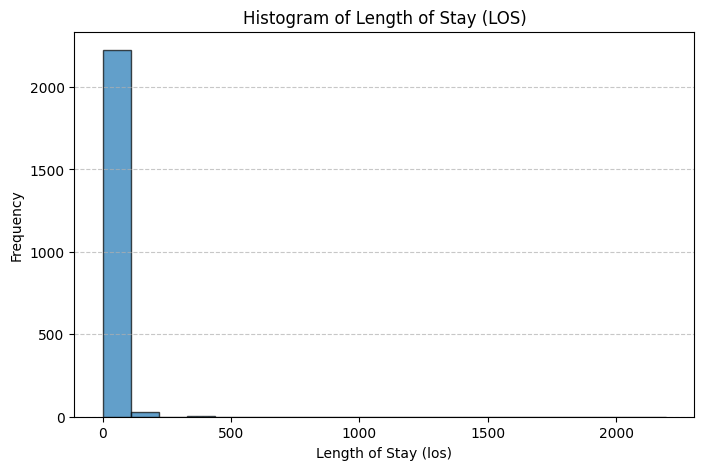

In [499]:
los_values = []

for val in merged_final_tsqic_redcap_access['los']:
    if isinstance(val, list):  # If it's a list, extend the list
        los_values.extend(val)
    elif pd.notna(val):  # If it's a single number, append it
        los_values.append(val)

# Convert to numeric array
los_values = np.array(los_values, dtype=float)

# Convert los_values to a pandas Series for easier stats calculation
los_series = pd.Series(los_values)

# Compute statistics
stats = {
    "Count": los_series.count(),
    "Mean": los_series.mean(),
    "Median": los_series.median(),
    "Min": los_series.min(),
    "Max": los_series.max()
}

# Convert to DataFrame for better visualization
stats_df = pd.DataFrame(stats, index=["Value"]).T
print(stats_df)

# Plot histogram before removing outliers
plt.figure(figsize=(8, 5))
plt.hist(los_values, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Length of Stay (los)")
plt.ylabel("Frequency")
plt.title("Histogram of Length of Stay (LOS)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [500]:
# Function to filter out rows where 'los' is a single value and greater than 60
def filter_los(val):
    return isinstance(val, (int, float)) and val > 60

df_filtered = merged_final_tsqic_redcap_access[~merged_final_tsqic_redcap_access['los'].apply(filter_los)]  # Keep rows where los does not meet the condition

df_filtered

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,surgery_arm_1,NaT,"[1, 0]",NaN,2,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaT,0,NaN,NaN,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,2010-02-20,0,16,NaN,2010-03-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,2011-08-26,0,0,NaN,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,2009-05-27,0,0,NaN,2009-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,1,4,0,1,1,2
8076,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,4,0,0,1,2
8077,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,NaN,1,1,2,3
8078,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [501]:
# Function to process 'los' and 'DischargeDate' when los is a list
def clean_los_discharge(row):
    if isinstance(row['los'], list):
        new_los = [val for val in row['los'] if val <= 60]  # Keep only values <= 60
        if len(new_los) < len(row['los']):  # If any values were removed
            row['los'] = new_los if new_los else None  # Set to None if list becomes empty
            if isinstance(row['DischargeDate'], list):
                row['DischargeDate'] = row['DischargeDate'][:len(new_los)] if new_los else None  # Trim DischargeDate accordingly
    return row

# Apply function to each row
df_filtered = df_filtered.apply(clean_los_discharge, axis=1)

merged_final_tsqic_redcap_access = df_filtered.copy()
merged_final_tsqic_redcap_access

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,surgery_arm_1,NaT,"[1, 0]",NaN,2,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaT,0,NaN,NaN,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,2010-02-20,0,16,NaN,2010-03-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,2011-08-26,0,0,NaN,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,2009-05-27,0,0,NaN,2009-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,1,4,0,1,1,2
8076,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,4,0,0,1,2
8077,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,NaN,1,1,2,3
8078,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


              Value
Count   2127.000000
Mean      12.776681
Median     8.000000
Min        0.000000
Max       60.000000


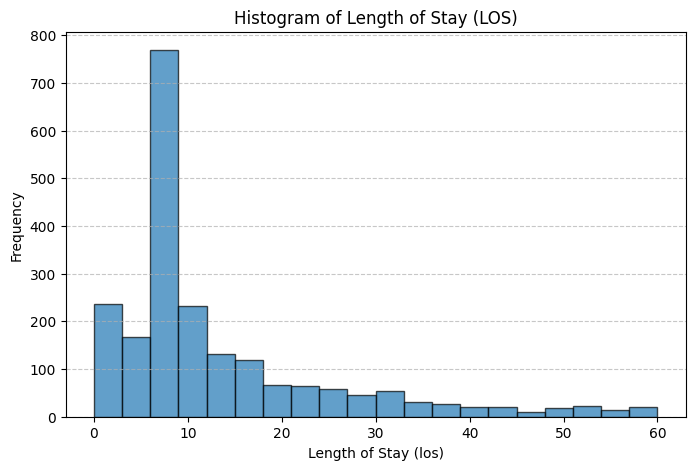

In [502]:
los_values = []

for val in merged_final_tsqic_redcap_access['los']:
    if isinstance(val, list):  # If it's a list, extend the list
        los_values.extend(val)
    elif pd.notna(val):  # If it's a single number, append it
        los_values.append(val)

# Convert to numeric array
los_values = np.array(los_values, dtype=float)

# Convert los_values to a pandas Series for easier stats calculation
los_series = pd.Series(los_values)

# Compute statistics
stats = {
    "Count": los_series.count(),
    "Mean": los_series.mean(),
    "Median": los_series.median(),
    "Min": los_series.min(),
    "Max": los_series.max()
}

# Convert to DataFrame for better visualization
stats_df = pd.DataFrame(stats, index=["Value"]).T
print(stats_df)

# Plot histogram before removing outliers
plt.figure(figsize=(8, 5))
plt.hist(los_values, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Length of Stay (los)")
plt.ylabel("Frequency")
plt.title("Histogram of Length of Stay (LOS)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Print data

In [503]:
merged_final_tsqic_redcap_access

,id,redcap_event_name,operation_date,postop_comp,los,readmission_30d,DischargeDate,ge1,ge2,ge3,ge4,ge5,ge6
0,1,surgery_arm_1,NaT,"[1, 0]",NaN,2,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaT,0,NaN,NaN,2012-04-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,2010-02-20,0,16,NaN,2010-03-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,2011-08-26,0,0,NaN,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,2009-05-27,0,0,NaN,2009-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8075,1755,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,1,4,0,1,1,2
8076,1756,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,4,0,0,1,2
8077,1757,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,2,NaN,1,1,2,3
8078,1758,baseline_arm_1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [504]:
# Save to a new Excel file
merged_final_tsqic_redcap_access.to_excel("Merged_TSQIC_REDCap_ACCESS.xlsx", index=False)